In [1]:
%matplotlib

Using matplotlib backend: MacOSX


In [2]:
import os
import sys
from astropy.io import fits, ascii
from astropy import table
#from astropy.cosmology import FlatLambdaCDM
#from astropy.wcs import WCS

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
#from numpy import ma
#import pandas as pd
#from scipy import integrate
#from scipy import interpolate

In [3]:
from importlib import reload

In [4]:
#reload(romanz)

### read in the CANDELS/3DHST phot+specbasiscoeff catalog

In [13]:
photcat = table.Table.read("data/hlsp_candels_hst_wfc3_cos-tot-multiband_f160w_v1-1photom_sfr_mass_specbasiscoeffs_cat_20210430a.fits")

### TODO : add photoz info, add WGTMAP based on SN rate predictions

### Converting to a HOSTLIB

Extract just the useful information (useful to SN sims) for each galaxy and write it out to a SNANA HOSTLIB file. 
From the 3DHST catalog we get redshift, position and magnitude information: 

- z : best redshift from the 3DHST catalog
- RA, Dec
- observed AB mags in SDSS u,g,r,i,z and 2MASS J, H


The GalFit catalogs from Arjen Van Der Weil contain the following columns:

- COL 1,  NUMBER: ID from the Skelton et al. (2014) photometric catalogs from the 3D-HST team
- COL 2,  RA: from SExtractor, measured in F160W
- COL 3,  DEC: idem.
- COL 4,  f: FLAG value (0: good fit; 1: suspicious fit; 2: bad fit; 3: no fit -- see van der Wel et al. 2012)
- COL 5,  mag: total AB magnitude from best-fitting Sersic model (GALFIT)
- COL 6,  dmag: 1-sigma uncertainty in mag
- COL 7,  re: semi-major axis in arcsec of the ellipse that contains half of the total light in the best fitting Sersic model
- COL 8,  1-sigma uncertainty on re
- COL 9,  n: Sersic index of the best-fitting Sersic model
- COL 10, dn: 1-sigma uncertainty on n
- COL 11, q: axis ratio of the best fitting Sersic model
- COL 12, dq: 1-sigma uncertainty on q
- COL 13, pa: position angle in degrees (0: North; 90: East)
- COL 14, dpa: 1-sigma uncertainty on pa
- COL 15, sn: S/N as measured in the F???W filter, integrated over the F160W segmentation region

For the HOSTLIB file we get Sersic fit info, and HST J and H band magnitudes from this catalog. 


There are two sets of functions:  
- one set for defining the HOSTLIB entries (a header and a line for each galaxy)
- another set for making a weight map in the HOSTLIB (defining the weight based on the predicted SN rate per galaxy). 


In [14]:
photcat[:3]

pind,ra,dec,id,u_LSST,du,g_LSST,dg,r_LSST,dr,i_LSST,di,z_LSST,dz,y_WFIRST,dy,j_WFIRST,dj,h_WFIRST,dh,F184W_WFIRST,df184w,k,dk,redshift,F160Wmag,fwhm,logmass,logsfr,SPECBASIS00,SPECBASIS01,SPECBASIS02,SPECBASIS03,SPECBASIS04,SPECBASIS05,SPECBASIS06,SPECBASIS07,SPECBASIS08,SPECBASIS09,SPECBASIS10,SPECBASIS11,SPECBASIS12
int64,float64,float64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,53.0929947,-27.9545364,gs1,23.93974,0.033040933,22.866352,0.038804296,21.691248,0.009396017,20.952232,0.0090999035,20.554216,0.0077740215,20.30703,0.5,19.94556,0.0027467415,19.67943,0.0023008352,19.51768,0.0023008352,19.4425,0.0019764572,0.5303,19.58,6.46,10.432969093322754,0.6894269640570988,44232509124871.96,0.0,0.0,2197599623547933.2,0.0,0.0,1.4798293318676306e+16,0.0,0.0,1.722111254953224e+16,0.0,0.0,3097794561459855.0
1,53.1016846,-27.9584789,gs3,99.0,25.09782,99.0,27.66925,99.0,24.011257,99.0,30.337896,21.958466,0.027543243,21.812433,0.5,21.576134,0.0099698035,21.417574,0.011421934,21.37767,0.011421934,21.455383,0.019616662,0.264,21.37,15.85,8.890420913696289,-0.7488535283548492,246228619470717.75,765255471501749.2,0.0,159956197524723.6,0.0,0.0,3757599778152175.0,0.0,0.0,0.0,0.0,1419882039883566.5,259494566804606.03
2,53.1022797,-27.9586506,gs4,99.0,27.575985,99.0,28.607008,99.0,26.222107,99.0,30.451311,24.438059,0.33416545,24.37078,0.5,24.272863,0.1644557,24.113474,0.2648947,23.967882,0.2648947,23.817171,0.08241054,0.63,24.07,9.84,8.786041259765625,-0.9800616143790363,140795289555652.72,0.0,0.0,234165087807357.6,0.0,0.0,10822509475238.014,29757278930445.56,102348995330288.19,0.0,0.0,65156779587992.66,0.0


In [21]:

_HOSTLIB_HEADER = """
VARNAMES: GALID RA_GAL  DEC_GAL      ZTRUE      ZERR     logsfr   logmass  logssfr   SPECBASIS00 SPECBASIS01 SPECBASIS02 SPECBASIS03 SPECBASIS04 SPECBASIS05 SPECBASIS06 SPECBASIS07 SPECBASIS08 SPECBASIS09 SPECBASIS10 SPECBASIS11 SPECBASIS12
"""

# OLD HOSTLIB HEADER LINE
#_HOSTLIB_HEADER = """
#VARNAMES: GALID RA_GAL  DEC_GAL      ZTRUE      ZERR     ZPHOT  ZPHOTERR    logsfr   logmass  logssfr hstj_obs  hsth_obs n0_Sersic a0_Sersic b0_Sersic a_rot eazy_coeff00 eazy_coeff01 eazy_coeff02 eazy_coeff03 eazy_coeff04 eazy_coeff05 eazy_coeff06 eazy_coeff07 eazy_coeff08 eazy_coeff09 eazy_coeff10 eazy_coeff11 eazy_coeff12

#"""


zbesterr = 0.001
    
def mk_hostlib_line(linedat):
    """ Extract galaxy info  that is useful for SN simulations from a 
    merged 3DHST+GalFit catalog.  Return a string in the SNANA HOSTLIB format
    """
    #  OLD STUFF, NEEDS REFRESHING 
    # question for Rick Kessler: can a SNANA HOSTLIB handle asymmetric z errors? 
    # zbesterr = (linedat['z_best_u68']-linedat['z_best_l68'])/2.   # assuming 'No.'
    # zphoterr = (linedat['z_phot_u68']-linedat['z_phot_l68'])/2.   # assuming 'No.'

    # Galfit: pa: position angle in degrees (0: North; 90: East)
    # SNANA:  “a_rot” is the rotation angle (in degrees) of the major axis w.r.t. the +RA coordinate. 
    # If North is up and East is to the right, a_rot is measured clockwise, from the East toward the South.
    #a_rot = linedat['pa'] - 90 
    #if a_rot < 0 : 
    #    a_rot += 180

    outline = ("GAL: {:d} " + 2*"{:10.5f}"+ 5*"{:10.4f}" + 
               # 2*"{:8.2f}"+ 4*"{:10.4f}" + 
               13*"{:12.5e}" + "\n").format(
        linedat['pind'], linedat['ra'], linedat['dec'], 
        linedat['redshift'], zbesterr, # linedat['z_peak_phot'], zphoterr, 
        linedat['logsfr'], linedat['logmass'], linedat['logsfr']-linedat['logmass'],
        #-2.5*np.log10(linedat['L156'])+25, 
        #-2.5*np.log10(linedat['L157'])+25, 
        #-2.5*np.log10(linedat['L158'])+25, 
        #-2.5*np.log10(linedat['L159'])+25, 
        #-2.5*np.log10(linedat['L160'])+25, 
        #-2.5*np.log10(linedat['L161'])+25, 
        #-2.5*np.log10(linedat['L162'])+25, 
        #linedat['mag_j129'], linedat['mag_h158'],
        #linedat['n'], linedat['re'], linedat['re']*linedat['q'], a_rot, 
        linedat['SPECBASIS00'], linedat['SPECBASIS01'], linedat['SPECBASIS02'], 
        linedat['SPECBASIS03'], linedat['SPECBASIS04'], linedat['SPECBASIS05'], 
        linedat['SPECBASIS06'], linedat['SPECBASIS07'], linedat['SPECBASIS08'], 
        linedat['SPECBASIS09'], linedat['SPECBASIS10'], linedat['SPECBASIS11'], 
        linedat['SPECBASIS12']
    )
    return(outline)

### These two functions bring it all together
1. construct a weight map file that can apply to any CANDELS/3DHST-based HOSTLIB
2. constructing a HOSTLIB file from an input merged catalog

In [22]:
def mk_wgtmap_file(wgtmapfilename):
    """Make a SNANA HOSTLIB WGTMAP file that defines a parameterized
    weightmap using the Andersen & Hjorth 2017 SN rate model, which 
    predicts the SN rate for each galaxy based on that galaxy's sSFR.
    """    
    fout = open(wgtmapfilename, mode='w')
    fout.write(_WGTMAP_HEADER_SSFR)
    wgtmap_block = mk_wgtmap_block()
    fout.write(wgtmap_block)
    fout.close()
    return

def mk_hostlib_file(cat, hostlib_filename, clobber=True, verbose=True):
    """Construct a SNANA HOSTLIB file from the given catalog, which must be the 
    result of merging a 3DHST and a GalFit catalog. 
    """
    if not clobber and os.path.exists(hostlib_filename):
        print("{} exists. Not clobbering.".format(hostlib_filename))
        return(-1)    
        
    fout = open(hostlib_filename, mode='w')
    fout.write(_HOSTLIB_HEADER)
    for i in range(len(cat)):
        fout.write(mk_hostlib_line(cat[i]))
    fout.close()
    return

In [23]:
mk_hostlib_file(photcat, "data/HOSTGAL_SPECSIM_HOSTLIB_20210503a.txt")

KeyError: 'lsfr'

## Interlude:  checking on some of the peculiarly large high-z galaxies

In [17]:
fieldname = 'cosmos'
cat_trim = mk_merged_catalog(fieldname)
cat_trim = mk_weight_column(cat_trim, snr_model='AH17')

Selected 18499 of 33879 galaxies  with ok redshifts, Sersic fits, sSFR, and mass data.
cosmos galfit catalog merged with 3DHST catalog successfully.
Max RA discrepancy = -0.0 arcsec
Max Dec discrepancy = 0.0018000000002516003 arcsec
Added/updated SN rate weight column using AH17 model


/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


### identify galaxies that are unusually large

In [18]:
FLCDM = FlatLambdaCDM(H0=70, Om0=0.3)
z = np.array(cat_trim['z_best'])
mu = FLCDM.distmod(z).value
a0 = np.array(cat_trim['re'])  # Sersic fit major axis length in arcsec
M = cat_trim['mag_h158']-mu
a0_thresh = 3
ibig = np.where(a0>a0_thresh)[0]

In [19]:
def plot_hexbin_scatter(ax, xval, yval, xlabel='x values', ylabel='y values'):
    """Plot yval vs xval as a combined hexbin and scatter plot, highlighting in red 
    the galaxies that are unusually large"""
    ax.plot(xval, yval, color='k', ms=2, marker='.', ls=' ', zorder=-10)
    hexbinout = ax.hexbin(xval, yval, gridsize=30, cmap=cm.Greys_r, mincnt=20, zorder=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(xval[ibig], yval[ibig], color='r', ms=3, 
            marker='.', ls=' ', zorder=10)
    return(hexbinout)

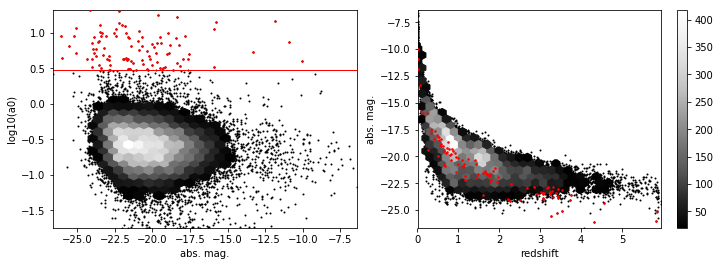

In [20]:
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(121)

xval = M
yval = np.log10(a0)
plot_hexbin_scatter(ax1, xval, yval, xlabel='abs. mag.', ylabel='log10(a0)')
ax1.axhline(np.log10(a0_thresh), color='r', lw=1)

ax2 = fig.add_subplot(122)
xval = z
yval = M
hexbinout = plot_hexbin_scatter(ax2, xval, yval, xlabel='redshift', ylabel='abs. mag.')
ax.plot(np.log10(z), M-np.log10(z)*6, marker='.', ls=' ',ms=2)

plt.colorbar(hexbinout)

### Show thumbnails for some unusually large galaxies

In [21]:
from astropy import coordinates
from astropy import units as u

In [22]:
# Read in the COSMOS mosaic
mosaic = fits.open("mosaics/hlsp_candels_hst_wfc3_cos-tot_f160w_v1_0_drz.fits")
wcsobj = WCS(mosaic[0].header)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


In [23]:
ra_big = np.array(cat_trim['ra'][ibig])*u.degree
dec_big = np.array(cat_trim['dec'][ibig])*u.degree
x_big, y_big = wcsobj.wcs_world2pix(ra_big, dec_big, 1)


ra = np.array(cat_trim['ra'])*u.degree
dec = np.array(cat_trim['dec'])*u.degree
x_all, y_all = wcsobj.wcs_world2pix(ra, dec, 1)

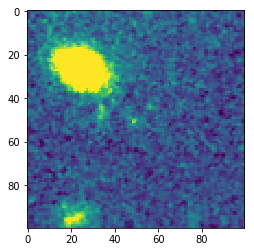

In [24]:
i=ibig[10]
x,y = int(x_all[i]), int(y_all[i])
dxy=50 # half of the stamp size
mosaic_stamp = mosaic[0].data[y-dxy:y+dxy,x-dxy:x+dxy]
plt.imshow(mosaic_stamp, vmin=-0.01, vmax=0.03)

## Define functions for Summmary plots from a trimmed catalog

In [25]:
def plot_weighted_redshift_hist(z, weights, axnum=1, binsize=0.2, label='', 
                                ncol=4, nrow=2, fig=None, **kwargs):    
    if fig is None:
        fig = plt.gcf()
    ax = fig.add_subplot(nrow, ncol, axnum)
    histout = ax.hist(z, bins=np.arange(0,5,binsize), range=(0,5), weights=weights, 
                      **kwargs)
    ax.set_xlabel('redshift')
    ax.set_ylabel(label)
    return(ax)

def plot_catalog_summary(cat, catalog_name):
    """
    Make some plots showing summaries of the SN host galaxy catalog data
    """
    fig = plt.figure(figsize=[12,7])
    fig.subplots_adjust(wspace=0.4, hspace=0.4)

    z = cat['z_best']
    snr = cat['snr_AH17_smooth']
    sfr = 10**cat['lsfr']
    mass = 10**cat['lmass']    

    # total SNR, binned by redshift
    ax2 = plot_weighted_redshift_hist(z, snr, 
                                      axnum=2, color='b', histtype='step', lw=2, 
                                      label = 'SN Rate [yr-1]')

    # total SFR, binned by redshift
    ax3 = plot_weighted_redshift_hist(z, sfr, axnum=3, color='darkorange', histtype='step', lw=2, 
                                      label = 'SFR [Msun yr-1]')


    # total mass, binned by redshift
    ax4 = plot_weighted_redshift_hist(z, mass, axnum=4, color='g', histtype='step', lw=2, 
                                      label = 'Galaxy Mass [Msun]')

    # Histogram of redshifts
    ax5 = fig.add_subplot(2, 4, 5)
    ax5.set_ylabel('Galaxy Count')
    histout = ax5.hist(z, bins=np.arange(0,5,0.2), color='r')
    ax5.set_xlabel('redshift')


    # histogram of galaxy masses ( log10(mass) )
    ax5 = fig.add_subplot(2, 4, 8)
    histout = ax5.hist(cat['lmass'], bins=np.arange(5,13,0.2), color='g')
    ax5.set_xlabel('log10(Mass/Msun)')

    # histogram of Sersic index
    ax6 = fig.add_subplot(2, 4, 7)
    histout = ax6.hist(cat['n'], color='m')#, bins=np.arange(5,13,0.2), color='0.5')
    ax6.set_xlabel('Sersic Index')

    ax7 = fig.add_subplot(2, 4, 6)
    histout = ax7.hist(cat['snr_AH17_smooth'], bins=np.linspace(0,0.05,50), color='b')
    ax7.set_yscale('log')
    ax7.set_xlabel('SN Rate')


    catalog_info = """
{0}\n
N = {1:d}
""".format(catalog_name, len(cat))
    fig.text(0.1, 0.9, catalog_info, transform=fig.transFigure, ha='left', va='top',
            fontsize=18)

In [26]:
def plot_mag_hist_at_z(cat, zval, band='V_rest', dz=0.1, ax=None):
    if ax is None:
        ax = plt.gca()
    iz = np.where((cat['z_best']<zval+dz) & (cat['z_best']>zval-dz))[0]

    if band=='U_rest':
        m = 25. - 2.5*np.log10(cat['L135'][iz])
    elif band=='V_rest':
        m = 25. - 2.5*np.log10(cat['L137'][iz])
    elif band=='I_rest':
        I = 25. - 2.5*np.log10(cat['L139'][iz])
    elif band=='u':
        m = 25. - 2.5*np.log10(cat['L156'])[iz]
    elif band=='r':
        r = 25. - 2.5*np.log10(cat['L158'])[iz]
    elif band=='z':
        z = 25. - 2.5*np.log10(cat['L160'])[iz]

        #plt.scatter(u-r, r-z, marker='.', color='k', alpha=0.2)
    histout = ax.hist(m, bins=np.arange(18,30,0.5))
    ax.text(0.05, 0.95, "z={:.2f}+-{:.2f}".format(zval,dz), transform=ax.transAxes,
           ha='left', va='top', fontsize=14)
    return
    
def plot_restV_histograms(cat, field_name):
    fig = plt.figure(figsize=[12,8])
    #fig.subplots_adjust(wspace=0.4, hspace=0.2)
    ax1 = fig.add_subplot(2, 4, 1)

    for i in range(1,9):
        if i>1:
            ax = fig.add_subplot(2, 4, i, sharey=ax1)
        else:
            ax = ax1
        plot_mag_hist_at_z(cat, zval=0.4*i, dz=0.2, band='V_rest', ax=ax)
    #ax1.set_ylim(0,800)
    fig.text(0.5, -0.05, "Apparent Magnitude in rest-frame V band", 
             transform=fig.transFigure, ha='center', va='bottom', fontsize=18)
    fig.text(-0.05, 0.5, "Number of Galaxies in {} Catalog".format(field_name),
             transform=fig.transFigure, ha='left', va='center', 
             fontsize=18, rotation=90)
    plt.tight_layout()
    return


## Make the files for SNANA and summary plots for All 5 CANDELS Fields

* First make a weight map file (common for all fields)
* then for each  merged catalog: 
  * compute SN rates and trim bad entries
  * construct the HOSTLIB file

In [27]:
mk_wgtmap_file('wgtmap_for_candels3dhst_hostlibs.txt')

Selected 21684 of 41200 galaxies  with ok redshifts, Sersic fits, sSFR, and mass data.
aegis galfit catalog merged with 3DHST catalog successfully.
Max RA discrepancy = -0.0 arcsec
Max Dec discrepancy = 0.0018000000210349754 arcsec
Added/updated SN rate weight column using AH17 model


Selected 21994 of 50507 galaxies  with ok redshifts, Sersic fits, sSFR, and mass data.
goodss galfit catalog merged with 3DHST catalog successfully.
Max RA discrepancy = -0.0 arcsec
Max Dec discrepancy = 0.0070200000052977884 arcsec
Added/updated SN rate weight column using AH17 model


Selected 18346 of 38279 galaxies  with ok redshifts, Sersic fits, sSFR, and mass data.
goodsn galfit catalog merged with 3DHST catalog successfully.
Max RA discrepancy = 0.05016221986368405 arcsec
Max Dec discrepancy = 0.01407600001357423 arcsec
Added/updated SN rate weight column using AH17 model


Selected 18499 of 33879 galaxies  with ok redshifts, Sersic fits, sSFR, and mass data.
cosmos galfit catalog merged with 3DH

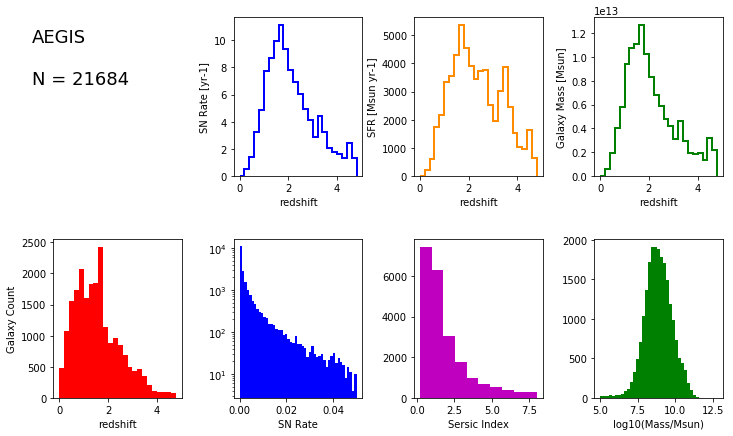

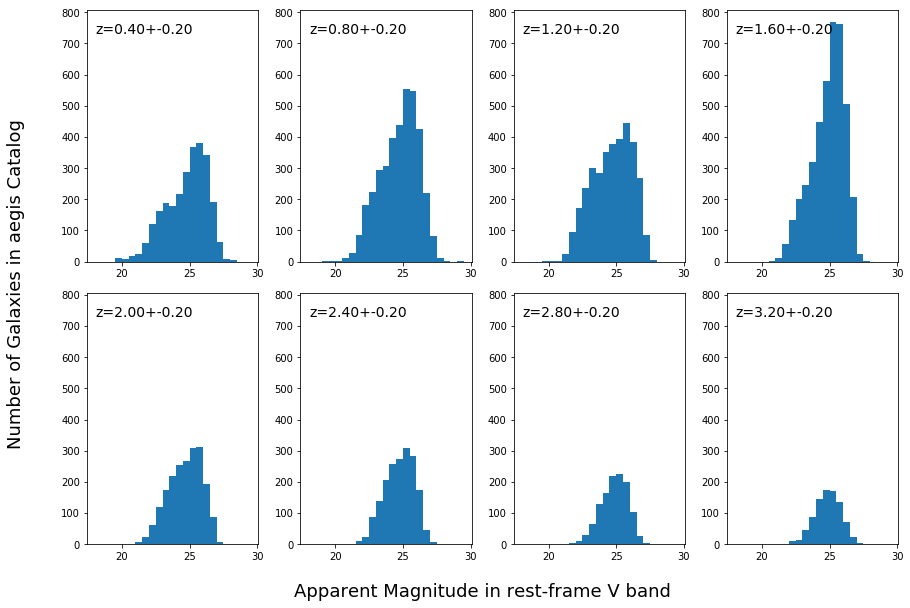

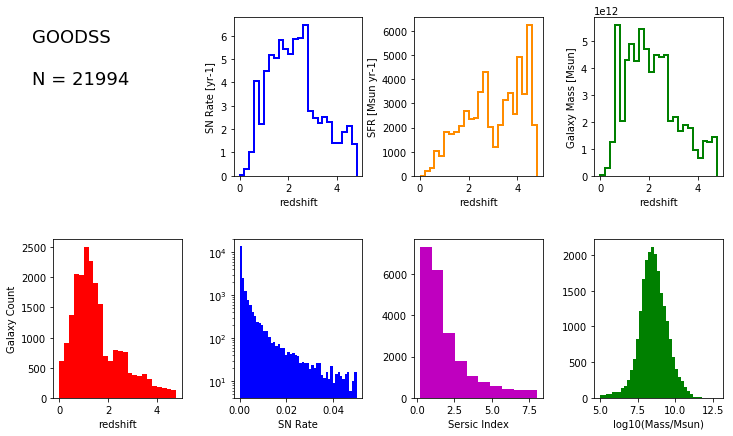

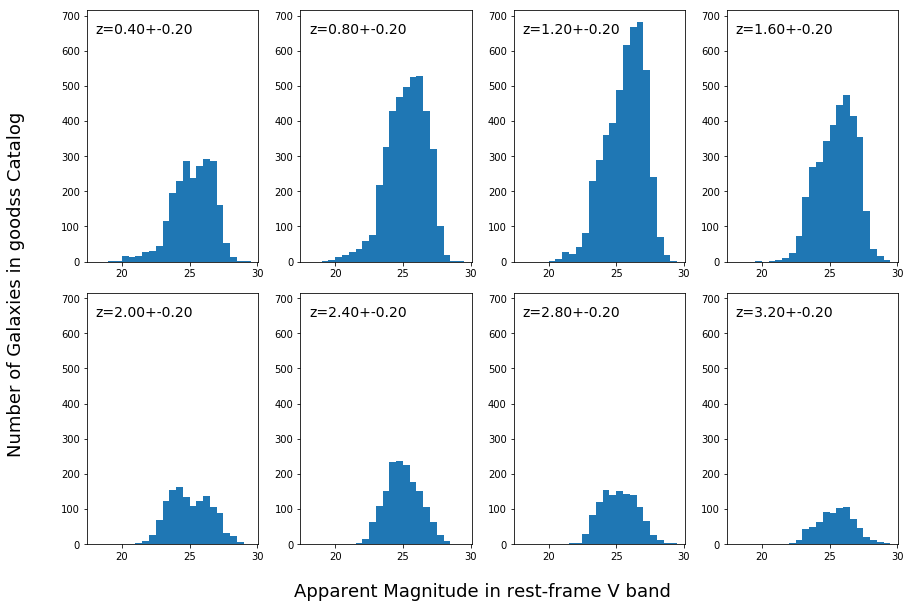

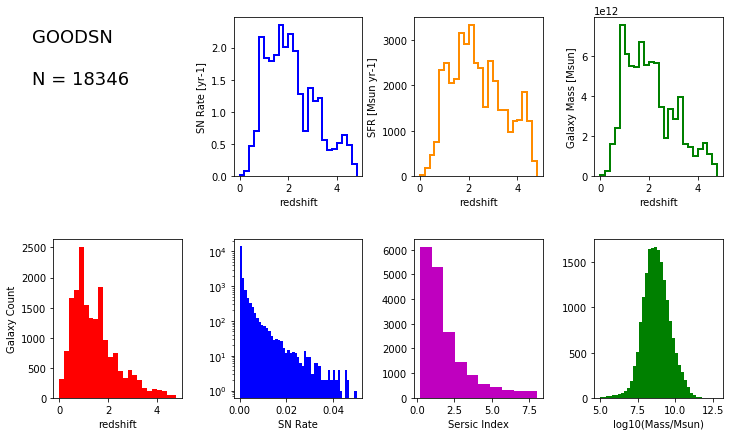

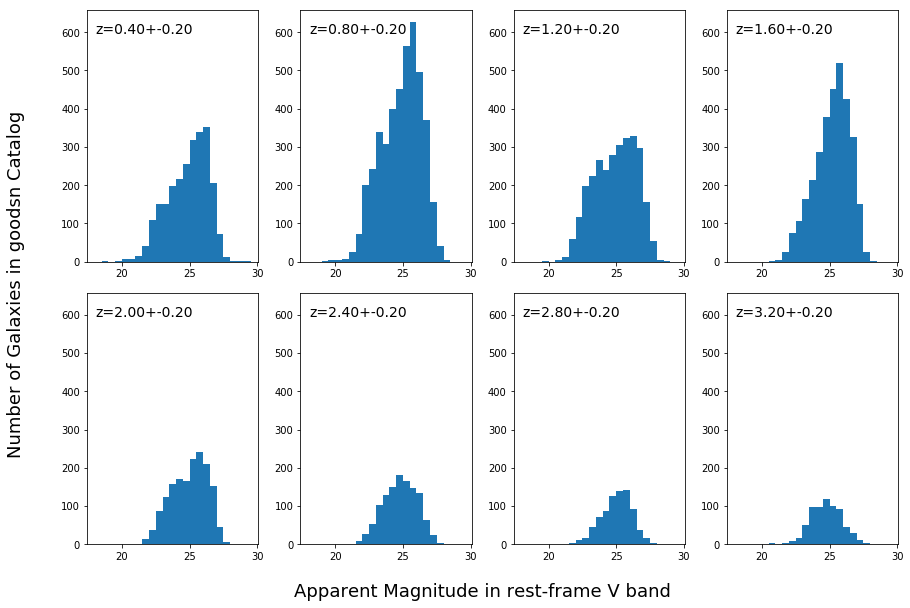

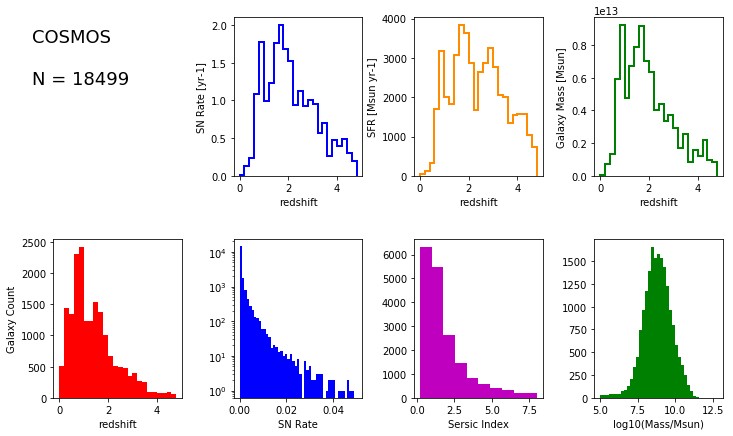

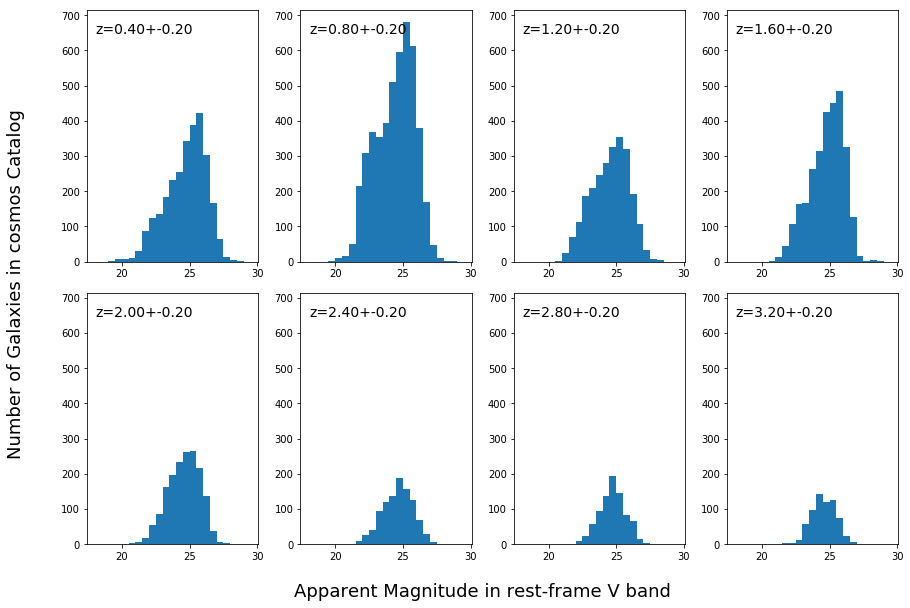

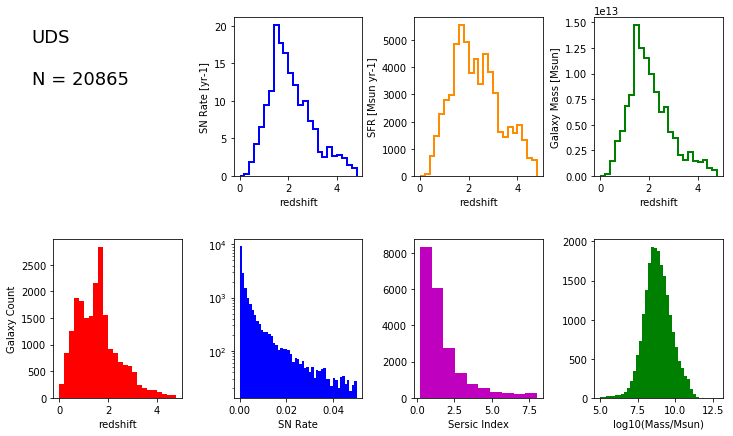

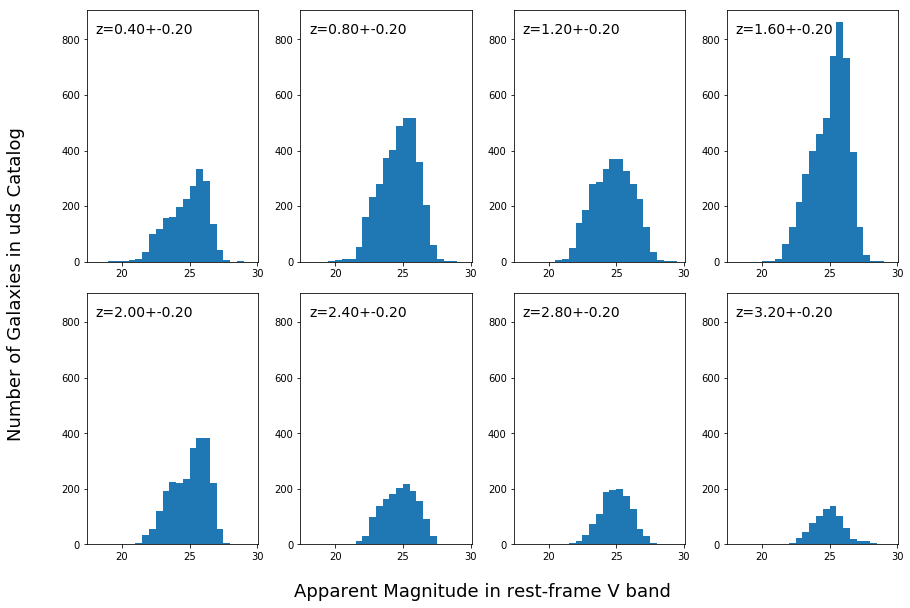

In [28]:
catlist = []
for fieldname in ['aegis', 'goodss', 'goodsn', 'cosmos', 'uds']:
    cat_trim = mk_merged_catalog(fieldname)
    cat_trim = mk_weight_column(cat_trim, snr_model='AH17')
    catlist.append(cat_trim)
    mk_hostlib_file(cat_trim, '{}_hostlib.txt'.format(fieldname))
    print('\n')
    plot_catalog_summary(cat_trim, fieldname.upper())
    plt.savefig("{}_catalog_summary.png".format(fieldname))

    plot_restV_histograms(cat_trim, fieldname)
    plt.savefig("{}_catalog_mag_hist.png".format(fieldname))

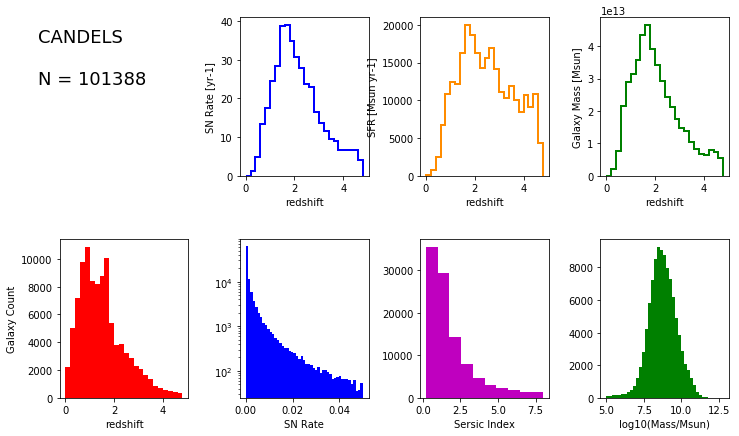

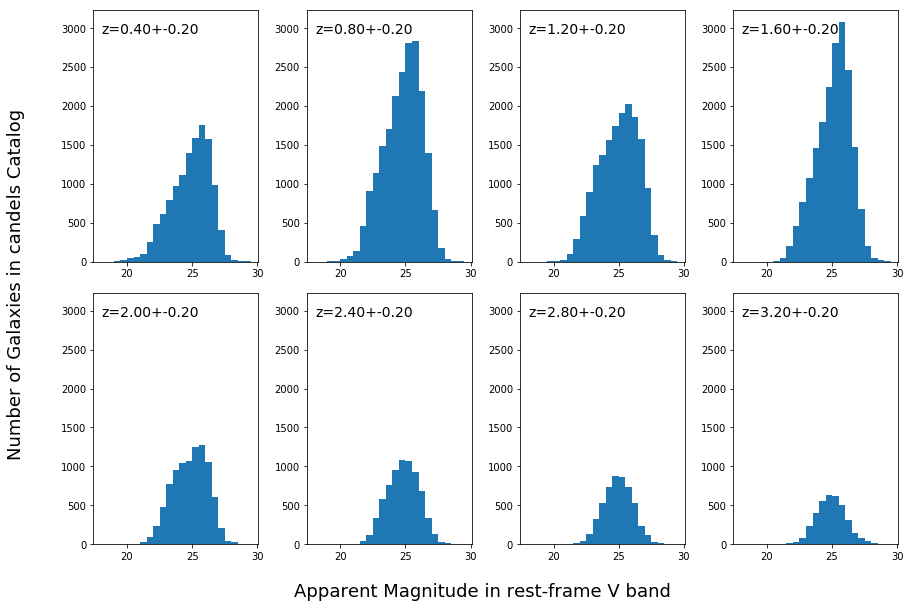

In [29]:
cat_trim = table.vstack(catlist, join_type='exact')
fieldname = 'candels'

mk_hostlib_file(cat_trim, '{}_hostlib.txt'.format(fieldname))
print('\n')

plot_catalog_summary(cat_trim, fieldname.upper())
plt.savefig("{}_catalog_summary.png".format(fieldname))

plot_restV_histograms(cat_trim, fieldname)
plt.savefig("{}_catalog_mag_hist.png".format(fieldname))


### Write out the EazyPy spectral templates

Extract the EazyPy template data from any of the EazyPy catalog files, and write out as separate ascii data files.

In [30]:
def mk_eazypy_template_datafile(outfilename='eazy_13_spectral_templates.dat'):
    fieldname = 'uds'  # any field will do. 
    filepath_data = 'eazypy/{0}_3dhst.v4.1.eazypy.data.fits'.format(fieldname)
    assert os.path.exists(filepath_data)
    hdu = fits.open(filepath_data)

    templ_wave = hdu['TEMPL'].data # rest-frame wavelength, Angstroms
    templ_flux = hdu['TEMPF'].data # template flux density for AB zeropoint = 25

    wave_column = table.Column(data=templ_wave, name='wavelength_angstroms')
    flux_columns = [table.Column(data=templ_flux[i], 
                                 name='eazyspectemp{:02d}'.format(i))
                    for i in range(len(templ_flux))]

    column_list = [wave_column] + flux_columns
    templ_data = table.Table(column_list)
    templ_data.write(outfilename, format='ascii.commented_header', overwrite=True)
    print("Wrote out Eazy spectral templates to {}".format(outfilename))
    return(templ_data)

In [31]:
templ_data = mk_eazypy_template_datafile()


Wrote out Eazy spectral templates to eazy_13_spectral_templates.dat
